<a href="https://colab.research.google.com/github/AmrMomtaz/Reviews-Classification/blob/main/Bert_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movies reviews classification using BERT**

## Problem Statement

IMDB is the most globally famous movie reviews website where you can publish a review for
any film you watched. Classifying the positive reviews and the negative ones can be useful for
several purposes such as giving an overall rating for the film or making statistical analysis about
the preferences of people from different countries, age levels, etc... So IMDB dataset is released
which composed of 50k reviews labeled as positive or negative to enable training movie reviews
classifiers. Moreover, NLP tasks are currently solved based on pretrained language models such
as BERT. These models provide a deep understanding of both semantic and contextual aspects
of language words, sentences or even large paragraphs due to their training on huge corpus for
very long time. In this notebook We will download the IMDB dataset from kaggle using this <a href = "https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews">
Link</a>. Then, we will train BERT based classifier for movie reviews.


## Installation

In this section we are going to get the problem data and install required libraries.
First you have to **upload** the kaggle API token to the current running sesion then run the following cells.

In [ ]:
# Cloning Data 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip
! rm /content/imdb-dataset-of-50k-movie-reviews.zip

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import torch
from torch import nn
from transformers import BertModel


mkdir: cannot create directory ‘/root/.kaggle’: File exists
 51% 13.0M/25.7M [00:00<00:00, 135MB/s]
100% 25.7M/25.7M [00:00<00:00, 159MB/s]
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data investigation

In [ ]:
# Creating dataframe and changing the lables to categorical
df = pd.read_csv('IMDB Dataset.csv')
df["sentiment"] = df["sentiment"].astype('category')
df["labels"] = df["sentiment"].cat.codes
df = df.drop(columns=['sentiment'])
df.head()

,review,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Index(['review', 'labels'], dtype='object')
(50000, 2)


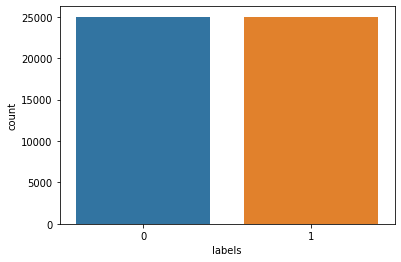

In [ ]:
# Checking if undersampling or oversampling is needed
print(df.columns)
print(df.shape)
sns.countplot(x='labels', data=df);

## Data Pre-processing

In [ ]:
# Lowercase all characters
df["review"] = df.review.apply(lambda x : str.lower(x))

# Removing punctiations and <br />
import re
df["review"] = df.review.apply(lambda x : " ".join(re.findall('[\w]+',x)))
df["review"] = df.review.apply(lambda x : x.replace('br', ''))

# Removing stop words
stop_words = set(stopwords.words('english'))
df["review"] = df.review.apply(
    lambda x : ' '.join(word for word in x.split() if word not in stop_words))
df["review"] = df.review.apply(lambda x : x.replace('   ', ' '))

# Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df["review"] = df.review.apply(lambda x : lemmatize_text(x))
df['review'] = df.review.apply(lambda x : ' '.join([str(elem) for elem in x]))

In [ ]:
df.head()

,review,labels
0,one reviewer mentioned watching 1 oz episode h...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


In [ ]:
df['review_length'] = df.review.apply(lambda x : len(x.split()))
print(df.review_length.describe())
df.drop(columns = 'review_length' , inplace = True)
df.head()

count    50000.000000
mean       119.501620
std         90.220921
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1430.000000
Name: review_length, dtype: float64


,review,labels
0,one reviewer mentioned watching 1 oz episode h...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Building Model

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(df.labels)
        self.texts = list(df.review.apply(lambda x :tokenizer(x, 
                               padding='max_length', max_length = 128, truncation=True,
                                return_tensors="pt")))

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Creating train and dev and test and stratifying

In [ ]:
# Stratify and split
train_list = []
test_list = []
val_list = []
grouped_df = df.groupby('labels')

for i, g in grouped_df:
    train, test, val = np.split(g, [int(.7 * len(g)), int(.8 * len(g))])

    train_list.append(train); test_list.append(test); val_list.append(val)

df_train = pd.concat(train_list)
df_val = pd.concat(test_list)
df_test = pd.concat(val_list)

df_train = df_train.sample(frac = 1)
df_val = df_val.sample(frac = 1)
df_test = df_test.sample(frac = 1)

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear_out = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)
        x = self.relu4(self.linear4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear_out(x))
        return x

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=1e-5)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output.squeeze(1), train_label.float())
                total_loss_train += batch_loss.item()

                y_pred_tag = torch.round(output.squeeze(1))
                acc = (y_pred_tag == train_label).sum()

                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output.squeeze(1), val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    y_pred_tag = torch.round(output.squeeze(1))
                    acc = (y_pred_tag == val_label).sum()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_accuracy.append(total_acc_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_accuracy.append(total_acc_val / len(val_data))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 1 | Train Loss:  0.021                 | Train Accuracy:  0.818                 | Val Loss:  0.322                 | Val Accuracy:  0.840


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 2 | Train Loss:  0.020                 | Train Accuracy:  0.846                 | Val Loss:  0.317                 | Val Accuracy:  0.865


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 3 | Train Loss:  0.020                 | Train Accuracy:  0.905                 | Val Loss:  0.309                 | Val Accuracy:  0.935


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 4 | Train Loss:  0.019                 | Train Accuracy:  0.925                 | Val Loss:  0.306                 | Val Accuracy:  0.935


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 5 | Train Loss:  0.019                 | Train Accuracy:  0.965                 | Val Loss:  0.298                 | Val Accuracy:  0.955


In [ ]:
val_accuracy